# Optimal Portoflio

This notebook demonstrates how to use [Markowitz Portfolio](https://www.math.hkust.edu.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf) optimization to setup an optimal portfolio using the MultiInstrumentEnv.

> This notebook uses PyPortfolioOpt library to optimize the portfolio. You can install it using the following command:
> ```bash pip install PyPortfolioOpt```

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import deeptrade.env
from deeptrade.env import HoldAgent, EWMACAgent, BreakoutAgent
import deeptrade.util.finance as futils

COLOURS = [[0, 18, 25], [0, 95, 115], [10, 147, 150], [148, 210, 189], [233, 216, 166], [238, 155, 0], [202, 103, 2], [187, 62, 3], [174, 32, 18], [155, 34, 38]]
COLOURS = [[value/255 for value in rgb] for rgb in COLOURS]

## MultiInstrumentEnv

The [MultiInstrumentEnv](../deeptrade/env/multi_instrument.py) allows multiple to be traded together. Similar to [SingleInstrumentEnv](../deeptrade/env/single_instrument.py) `prices` follows similar structure to setup the environment. The following are used in `price_gen_info` to generate time-series data:

- `starting_prices`: Starting price for each instrument, $\bm{Y}_{0}$.
- `drifts`: Mean value for each instrument, $\bm{\mu}$, $[-1\times10^{-3}, 1\times10^{-4}]$.
- `covs`: Covariance for each instrument, $\bm{\Sigma}$.    
- `n_days`: Number of days to generate data over, $T$.

Shocks $\bm{Z}$ are modelled as a multivariate normal distribution, $\bm{Z} \sim \mathcal{N}(\bm{\mu}, \bm{\Sigma})$ and then multiplied by the sum of shocks over the time period:

$$
    \bm{Y}_{t} = \bm{Y}_{0} \exp\left(\sum_{i=1}^{t} \bm{Z}_{i}\right).
$$

This model has a tendency to explode over time when values get too large. To prevent this, the *Ornstein-Uhlenbeck* process is used to model mean reversion:

$$
    d\bm{Y}_{t} = \kappa(\bm{\mu} - \bm{Y}_{t})dt + \bm{\sigma} d\bm{Z}_{t},
$$

where $\kappa$ is mean reversion strength.

In [2]:
seed = 1
n_instruments = 10
starting_cash = 10000.0

def generate_covarinace_matrix(n: int) -> np.ndarray:
    # TODO: Make this work but keep the covariances smallish, maybe randomly none
    A = np.random.uniform(0.0, 0.5, size=(n, n))
    semi_definite_matrix = np.dot(A, A.T)
    diag = np.diag(semi_definite_matrix)
    normalized_matrix = semi_definite_matrix / np.sqrt(np.outer(diag, diag))
    epsilon = 1e-10
    positive_semi_definite_matrix = normalized_matrix + epsilon * np.eye(n)
    # np.fill_diagonal(positive_semi_definite_matrix, 1.0)
    return positive_semi_definite_matrix

S0 = np.random.uniform(100, 200, n_instruments)
mu = np.random.uniform(0.1, 0.6, n_instruments)
# cov_matrix = generate_covarinace_matrix(n_instruments)
# This is uncorrelated returns, extremely unrealistic
cov_matrix = np.random.uniform(0.1, 0.5, n_instruments)
cov_matrix = np.diag(cov_matrix)
n_steps = 252 * 5

price_gen_info = {
    "name": "GBM",
    "seed": seed,
    "S0": S0,
    "mu": mu,
    "cov_matrix": cov_matrix,
    "n_steps": n_steps
}
env = gym.make("MultiInstrument-v0", seed=seed, n_instruments=n_instruments, price_gen_info=price_gen_info, starting_cash=starting_cash, dt=1/252)

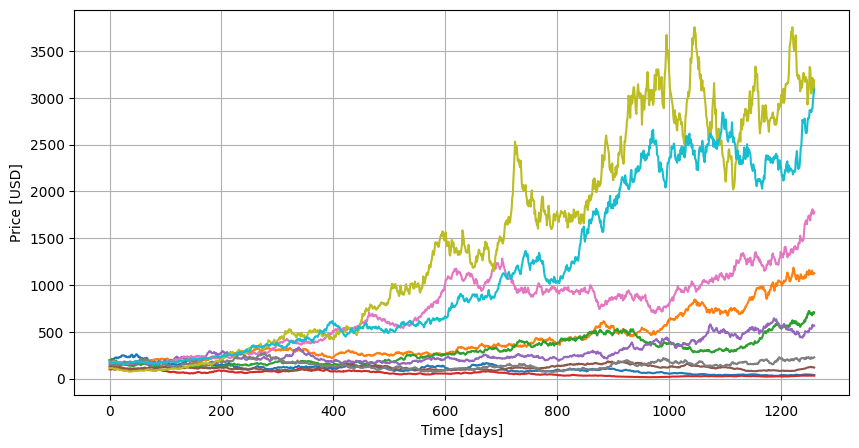

In [3]:
price_data = env.unwrapped.prices_data

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(n_instruments):
    ax.plot(price_data[i], label=f"Instrument {i}")
ax.grid()
# ax.legend()
ax.set_ylabel("Price [USD]")
ax.set_xlabel("Time [days]")
fig.show()

In [4]:
from pypfopt import risk_models
from pypfopt import plotting

dates = pd.date_range(start='1990-01-01', periods=price_data.shape[1], freq='D')
prices = pd.DataFrame(price_data.T, index=dates, columns=[f'Asset {i+1}' for i in range(price_data.shape[0])])
sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10
Asset 1,0.266618,-0.005711,0.000755,0.004598,0.006502,-0.007159,0.004104,0.004488,0.009397,-0.006359
Asset 2,-0.005711,0.135013,-0.002890,0.000133,0.006400,-0.000640,-0.002378,-0.012846,-0.002396,0.001617
Asset 3,0.000755,-0.002890,0.159685,0.001377,-0.002904,0.001197,0.005047,0.008536,-0.001426,-0.001105
Asset 4,0.004598,0.000133,0.001377,0.227183,-0.010416,0.005671,-0.003925,-0.008651,-0.000983,-0.003094
Asset 5,0.006502,0.006400,-0.002904,-0.010416,0.217195,-0.011254,0.001584,-0.003803,0.006829,0.002516
Asset 6,-0.007159,-0.000640,0.001197,0.005671,-0.011254,0.130393,0.001001,-0.006953,-0.007081,0.000279
Asset 7,0.004104,-0.002378,0.005047,-0.003925,0.001584,0.001001,0.102638,-0.006485,-0.003009,0.001092
Asset 8,0.004488,-0.012846,0.008536,-0.008651,-0.003803,-0.006953,-0.006485,0.425352,0.006200,-0.007792
Asset 9,0.009397,-0.002396,-0.001426,-0.000983,0.006829,-0.007081,-0.003009,0.006200,0.264004,-0.000284
Asset 10,-0.006359,0.001617,-0.001105,-0.003094,0.002516,0.000279,0.001092,-0.007792,-0.000284,0.139874


<Axes: >

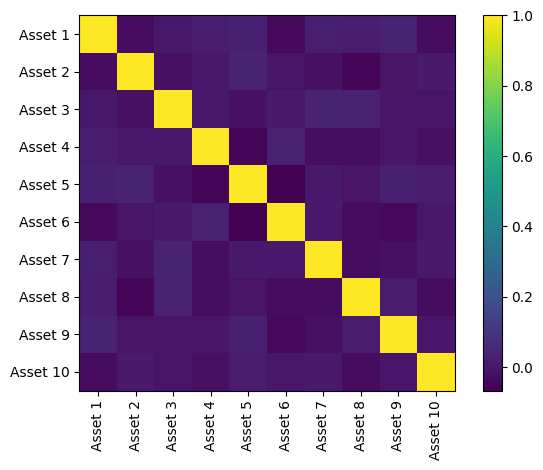

In [5]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

<Axes: >

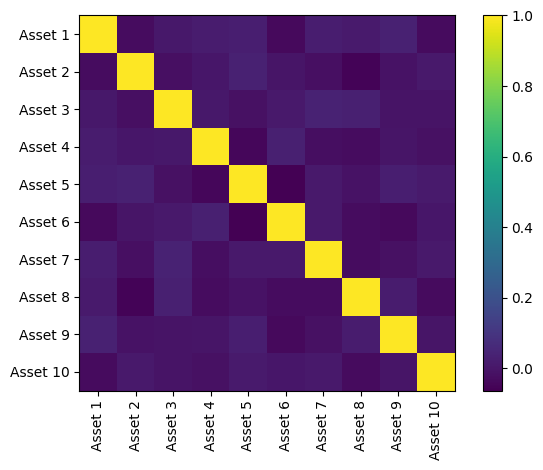

In [6]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True)

Asset 1     0.497768
Asset 2     0.220426
Asset 3     0.309990
Asset 4     0.385164
Asset 5     0.386468
Asset 6     0.201734
Asset 7     0.191763
Asset 8     0.705971
Asset 9     0.487459
Asset 10    0.238422
Name: mkt, dtype: float64
0.3653966039629364 0.14220868914315238


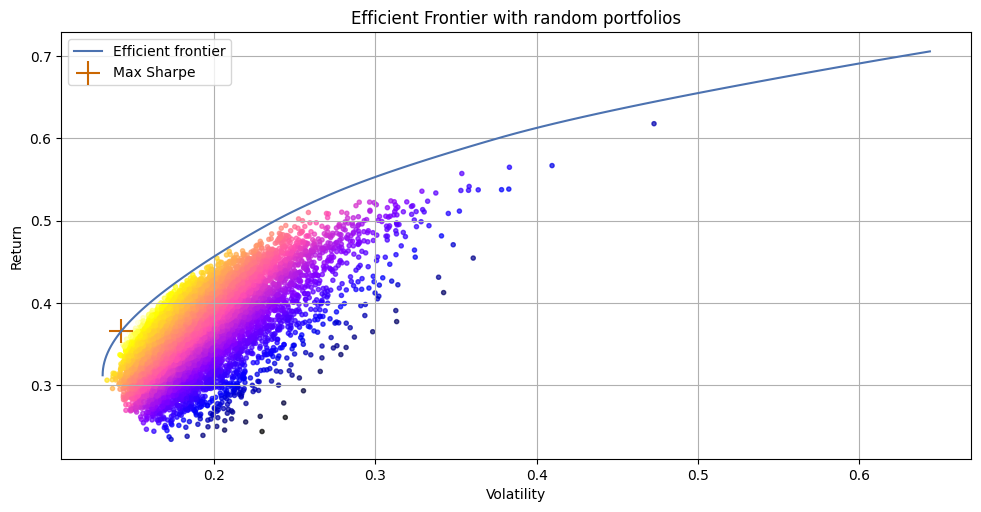

In [7]:
from pypfopt import EfficientFrontier
from pypfopt import expected_returns
mu = expected_returns.capm_return(prices)
ef = EfficientFrontier(mu, S)
print(mu)

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

fig, ax = plt.subplots(figsize=(10, 5))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False, verbose=True)

ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
print(ret_tangent, std_tangent)
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="gnuplot2", alpha=0.7)
ax.scatter(std_tangent, ret_tangent, marker="+", s=300, color=COLOURS[6], label="Max Sharpe")
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
ax.grid()
# fig.tight_layout()
fig.show()


# Basic Agent Performance

Comparing the performance of each agent on each dataset and plotting on efficient frontier.

In [8]:
pos_size = 0.01
agents = [HoldAgent, EWMACAgent, BreakoutAgent]
names = ["Hold", "EWMAC", "Breakout"]

agent_margins = {}

for agent_type, name in zip(agents, names):
    margins = {}
    for idi in range(n_instruments):
        agent = agent_type(env=env, pos_size=pos_size, instrument=idi)
        env.reset(seed=seed)
        terminated, truncated = False, False
        observations = []
        times = []
        obs, _ = env.reset(seed=seed)
        while (not terminated) and (not truncated):
            action = np.zeros(n_instruments)
            action[idi] = agent.act(obs)[idi]
            obs, reward, terminated, truncated, _ = env.step(action)
            observations.append(obs)

        observations = np.array(observations)
        margins[idi] = [obs['margin'] for obs in observations]
    agent_margins[name] = margins

/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
/home/quessy/.conda/envs/deeptrade-env/lib/python3.10/site-packages/deeptrade/env/agents/ewmac.py:43: RuntimeWarning: Mean of empty slice.
  slow = np.array(price_data[self.instrument][time-self.sl

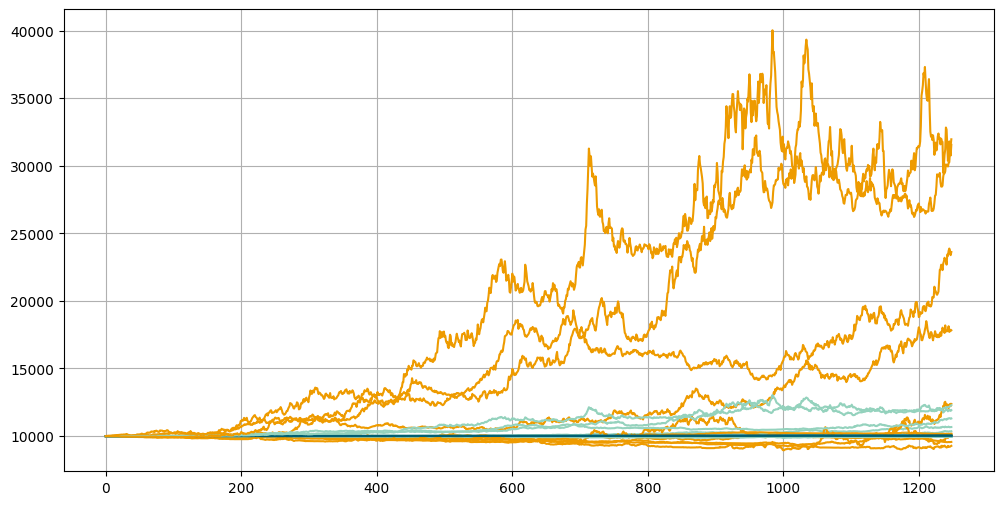

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# ax.plot(times, margins, label='Margin')
# print(agent_margins)
for idp in range(n_instruments):
    ax.plot(agent_margins["Hold"][idp], label=f"Margin {idp}", color=COLOURS[1])
    ax.plot(agent_margins["EWMAC"][idp], label=f"Margin {idp}", color=COLOURS[3])
    ax.plot(agent_margins["Breakout"][idp], label=f"Margin {idp}", color=COLOURS[5])
# ax.plot(times, prices[0, :len(times)])
ax.grid()

Asset Hold 0        0.019997
Asset Hold 1        0.020041
Asset Hold 2        0.020014
Asset Hold 3        0.019999
Asset Hold 4        0.020021
Asset Hold 5        0.019998
Asset Hold 6        0.020071
Asset Hold 7        0.019997
Asset Hold 8        0.020521
Asset Hold 9        0.020212
Asset EWMAC 0       0.020068
Asset EWMAC 1       0.023328
Asset EWMAC 2       0.021498
Asset EWMAC 3       0.020058
Asset EWMAC 4       0.021610
Asset EWMAC 5       0.019927
Asset EWMAC 6       0.025698
Asset EWMAC 7       0.020101
Asset EWMAC 8       0.055750
Asset EWMAC 9       0.036461
Asset Breakout 0    0.021474
Asset Breakout 1    0.046601
Asset Breakout 2    0.033286
Asset Breakout 3    0.020808
Asset Breakout 4    0.035619
Asset Breakout 5    0.020614
Asset Breakout 6    0.058647
Asset Breakout 7    0.020477
Asset Breakout 8    0.177491
Asset Breakout 9    0.099242
Name: mkt, dtype: float64
Expected annual return: 2.0%
Annual volatility: 0.2%
Sharpe Ratio: 0.18
Expected annual return: 10.1%
An

OrderedDict([('Asset Hold 0', np.float64(0.0)),
             ('Asset Hold 1', np.float64(0.0)),
             ('Asset Hold 2', np.float64(0.0)),
             ('Asset Hold 3', np.float64(0.0)),
             ('Asset Hold 4', np.float64(0.0)),
             ('Asset Hold 5', np.float64(0.0)),
             ('Asset Hold 6', np.float64(0.0)),
             ('Asset Hold 7', np.float64(0.0)),
             ('Asset Hold 8', np.float64(0.0)),
             ('Asset Hold 9', np.float64(0.0)),
             ('Asset EWMAC 0', np.float64(0.0)),
             ('Asset EWMAC 1', np.float64(0.0)),
             ('Asset EWMAC 2', np.float64(0.0)),
             ('Asset EWMAC 3', np.float64(0.0)),
             ('Asset EWMAC 4', np.float64(0.0)),
             ('Asset EWMAC 5', np.float64(0.0)),
             ('Asset EWMAC 6', np.float64(0.0)),
             ('Asset EWMAC 7', np.float64(0.0)),
             ('Asset EWMAC 8', np.float64(0.0)),
             ('Asset EWMAC 9', np.float64(0.0)),
             ('Asset Breakout 

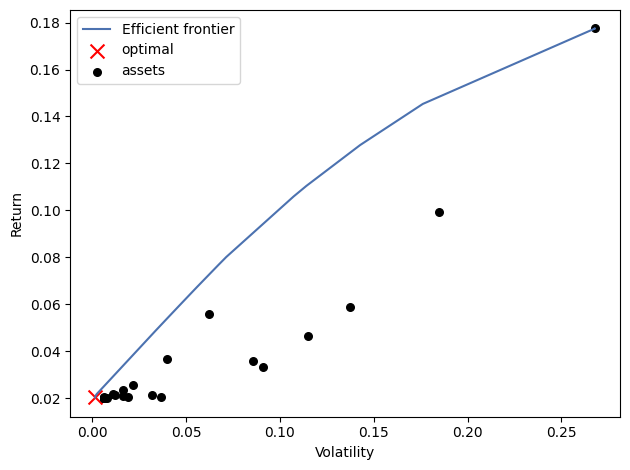

In [13]:
dfs = []

for name in names:
    max_length = max(len(m) for m in agent_margins[name].values())
    padded_margins = {k: np.pad(v, (0, max_length - len(v)), constant_values=np.nan) for k, v in agent_margins[name].items()}
    data = pd.DataFrame(padded_margins)
    dates = pd.date_range(start='1990-01-01', periods=data.shape[0], freq='D')
    df = pd.DataFrame(data.values, index=dates, columns=[f'Asset {name} {ida}' for ida in range(data.shape[1])])
    # print(df)
    dfs.append(df)

combined_df = pd.concat(dfs, axis=1)
sample_cov = risk_models.sample_cov(combined_df, frequency=252)
mu = expected_returns.capm_return(combined_df)
# mu.plot.barh(figsize=(10, 5))
from pypfopt import CLA, plotting
print(mu)
S = risk_models.CovarianceShrinkage(combined_df).ledoit_wolf()
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)
ax = plotting.plot_efficient_frontier(cla, showfig=False)

# ef = EfficientFrontier(mu, sample_cov)

# fig, ax = plt.subplots(figsize=(10, 5))
# plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False, verbose=True)

# ef2 = EfficientFrontier(mu, sample_cov)
# ef2.max_sharpe()
# ret_tangent, std_tangent, _ = ef2.portfolio_performance()
# print(ret_tangent, std_tangent)
# ax.scatter(stds, rets, marker=".", c=sharpes, cmap="gnuplot2", alpha=0.7)
# ax.scatter(std_tangent, ret_tangent, marker="+", s=300, color=COLOURS[6], label="Max Sharpe")
# ax.set_title("Efficient Frontier with random portfolios")
# ax.legend()
# ax.grid()
# # fig.tight_layout()
# fig.show()

ef = EfficientFrontier(mu, S)
# ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.efficient_risk(target_volatility=0.1)
ef.portfolio_performance(verbose=True)
weights = ef.clean_weights()
weights


## Putting it all together

To design a complete portfolio based on these trading rules:
1. Simulate the performance of each agent on each instrument
2. Calculate the expected return and covariance matrix of the returns of each agent
3. Use Markowitz Portfolio optimization to find the optimal portfolio weights
4. Backtest this strategy on the MultiInstrumentEnv